In [1]:
"""!pip3 install fcapy[all]
!pip3 install frozendict
!pip3 install ipynb
!pip3 install sparselinear
!pip3 install bitsets
!pip3 install bitarray
import torch
!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip3 install git+https://github.com/pyg-team/pytorch_geometric.git"""

'!pip3 install fcapy[all]\n!pip3 install frozendict\n!pip3 install ipynb\n!pip3 install sparselinear\n!pip3 install bitsets\n!pip3 install bitarray\nimport torch\n!pip3 install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html\n!pip3 install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html\n!pip3 install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html\n!pip3 install git+https://github.com/pyg-team/pytorch_geometric.git'

# Import libs

In [2]:
import numpy as np
import pandas as pd

In [3]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [5]:
import neural_lib as nl

In [6]:
df = pd.read_csv('./data.csv', index_col=0)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,1
2,F,Flight,4,5,216,2,low,M,59,3088,1
3,A,Flight,2,2,183,4,low,M,48,3374,1
4,B,Flight,3,3,176,4,medium,M,10,1177,1
5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [7]:
df.shape

(10999, 11)

# Pipeline

# Step 0. Binarize the data

In [8]:
def bin_num_column(df_bin, col, start, finish, step):
    for i in range(start, finish, step):
        df_bin[col+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))

In [9]:
def bin_cat_column(df_bin, col, cats):
    for i in cats:
        df_bin[col+str(i)] = df[col] == i

In [10]:
df_bin = pd.DataFrame()
bin_cat_column(df_bin, 'Warehouse_block', ['D', 'F', 'A', 'B', 'C'])
bin_cat_column(df_bin, 'Warehouse_block', ['Flight', 'Ship', 'Road'])
bin_num_column(df_bin, 'Customer_care_calls', 2, 7, 2)
bin_num_column(df_bin, 'Customer_care_calls', 1, 5, 3)
bin_num_column(df_bin, 'Cost_of_the_Product', 96, 310, 400)
bin_num_column(df_bin, 'Prior_purchases', 2, 10, 3)
bin_cat_column(df_bin, 'Product_importance', ['low', 'medium', 'high'])
bin_cat_column(df_bin, 'Gender', ['M', 'F'])
bin_num_column(df_bin, 'Discount_offered', 1, 65, 20)
bin_num_column(df_bin, 'Weight_in_gms', 1000, 8000, 5000)
df_bin.head()

,Warehouse_blockD,Warehouse_blockF,Warehouse_blockA,Warehouse_blockB,Warehouse_blockC,Warehouse_blockFlight,Warehouse_blockShip,Warehouse_blockRoad,Customer_care_calls(2;4],Customer_care_calls(4;6],...,Product_importancemedium,Product_importancehigh,GenderM,GenderF,Discount_offered(1;21],Discount_offered(21;41],Discount_offered(41;61],Discount_offered(61;81],Weight_in_gms(1000;6000],Weight_in_gms(6000;11000]
ID,,,,,,,,,,,,,,,,,,,,,
1,True,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
2,False,True,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
3,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,True,False
4,False,False,False,True,False,False,False,False,True,False,...,True,False,True,False,True,False,False,False,True,False
5,False,False,False,False,True,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,False


In [34]:
df_bin['Reached_on_time'] = df['Reached.on.Time_Y.N'] == 0
df_bin.head()
df_bin.columns

Index(['Warehouse_blockD', 'Warehouse_blockF', 'Warehouse_blockA',
       'Warehouse_blockB', 'Warehouse_blockC', 'Warehouse_blockFlight',
       'Warehouse_blockShip', 'Warehouse_blockRoad',
       'Customer_care_calls(2;4]', 'Customer_care_calls(4;6]',
       'Customer_care_calls(6;8]', 'Customer_care_calls(1;4]',
       'Customer_care_calls(4;7]', 'Cost_of_the_Product(96;496]',
       'Prior_purchases(2;5]', 'Prior_purchases(5;8]', 'Prior_purchases(8;11]',
       'Product_importancelow', 'Product_importancemedium',
       'Product_importancehigh', 'GenderM', 'GenderF',
       'Discount_offered(1;21]', 'Discount_offered(21;41]',
       'Discount_offered(41;61]', 'Discount_offered(61;81]',
       'Weight_in_gms(1000;6000]', 'Weight_in_gms(6000;11000]',
       'Reached_on_time'],
      dtype='object')

In [12]:
df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,Warehouse_blockD,Warehouse_blockF,Warehouse_blockA,Warehouse_blockB,Warehouse_blockC,Warehouse_blockFlight,Warehouse_blockShip,Warehouse_blockRoad,Customer_care_calls(2;4],Customer_care_calls(4;6],...,Product_importancehigh,GenderM,GenderF,Discount_offered(1;21],Discount_offered(21;41],Discount_offered(41;61],Discount_offered(61;81],Weight_in_gms(1000;6000],Weight_in_gms(6000;11000],Reached_on_time
id,,,,,,,,,,,,,,,,,,,,,
h3178,False,False,False,False,True,False,False,False,True,False,...,False,True,False,True,False,False,False,True,False,True


In [13]:
df_bin.shape

(10999, 29)

Split the data to train and test

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

In [15]:
y_feat = 'Reached_on_time'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

In [16]:
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

In [17]:
X_train.sample()

,Warehouse_blockD,Warehouse_blockF,Warehouse_blockA,Warehouse_blockB,Warehouse_blockC,Warehouse_blockFlight,Warehouse_blockShip,Warehouse_blockRoad,Customer_care_calls(2;4],Customer_care_calls(4;6],...,Product_importancemedium,Product_importancehigh,GenderM,GenderF,Discount_offered(1;21],Discount_offered(21;41],Discount_offered(41;61],Discount_offered(61;81],Weight_in_gms(1000;6000],Weight_in_gms(6000;11000]
id,,,,,,,,,,,,,,,,,,,,,
h8982,True,False,False,False,False,False,False,False,False,True,...,True,False,False,True,True,False,False,False,True,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [18]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (7699 objects, 28 attributes, 66508 connections)
      |Warehouse_blockD|Warehouse_blockF|Warehouse_blockA|Warehouse_blockB|Warehouse_blockC|...|Discount_offered(21;41]|Discount_offered(41;61]|Discount_offered(61;81]|Weight_in_gms(1000;6000]|Weight_in_gms(6000;11000]|
h1589 |                |               X|                |                |                |...|                       |                       |                       |                       X|                         |
h10175|                |               X|                |                |                |...|                       |                       |                       |                       X|                         |
h326  |                |                |               X|                |                |...|                       |                      X|                       |                       X|                         |
h10059|                |                |                

In [19]:
%%time 
L = ConceptLattice.from_context(K_train, algo='Sofia', is_monotone=True)
len(L)

CPU times: user 2.22 s, sys: 58.7 ms, total: 2.28 s
Wall time: 2.29 s


102

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [20]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [21]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [22]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [23]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [24]:
"""vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
    mvr.swap_nodes(a, b)

for nodes, vert in [
    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
]:
    for a in nodes:
        mvr.place_node(a, mvr.posx[vert])"""

'vis.init_mover_per_poset(cn.poset)\nmvr = vis.mover\nfor a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:\n    mvr.swap_nodes(a, b)\n\nfor nodes, vert in [\n    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)\n]:\n    for a in nodes:\n        mvr.place_node(a, mvr.posx[vert])'

In [25]:
descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

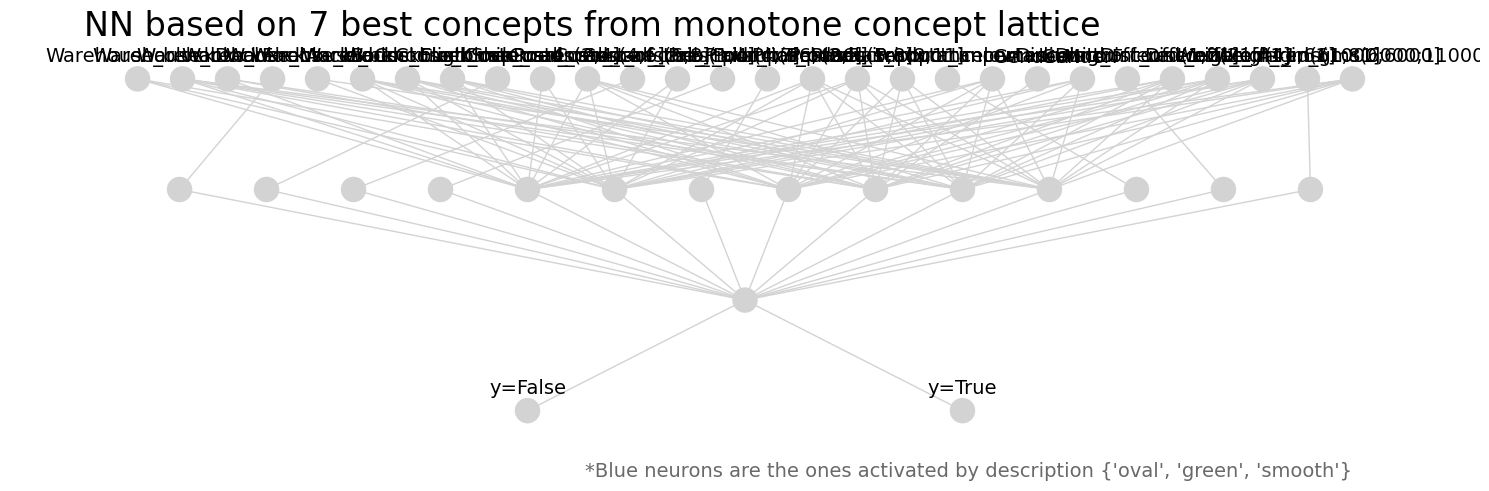

In [26]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [27]:
cn.fit(X_train, y_train)

To obtain the prediction

In [28]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [1 1 0 0 0 0 1 0 0 0]
Class prediction with probabilities [[4.6736243e-01 5.3263754e-01]
 [4.6304816e-01 5.3695178e-01]
 [5.6589770e-01 4.3410239e-01]
 [9.9931526e-01 6.8474014e-04]
 [6.8680191e-01 3.1319815e-01]
 [5.0343901e-01 4.9656102e-01]
 [4.6304816e-01 5.3695178e-01]
 [5.0343901e-01 4.9656102e-01]
 [5.2236027e-01 4.7763970e-01]
 [5.1773125e-01 4.8226881e-01]]
True class [False  True False False  True  True  True  True  True False]


In [29]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))
print(classification_report(y_test.values.astype('int'), y_pred))

Recall score: 0.4467005076142132
F1     score: 0.47203065134099614
Accuracy score: 0.5824242424242424
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1921
           1       0.50      0.45      0.47      1379

    accuracy                           0.58      3300
   macro avg       0.57      0.56      0.56      3300
weighted avg       0.58      0.58      0.58      3300



Let us look at the fitted weights of edges

In [30]:
edge_weights = cn.edge_weights_from_network()

/Users/brtshohin/Library/Python/3.9/lib/python/site-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:653.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


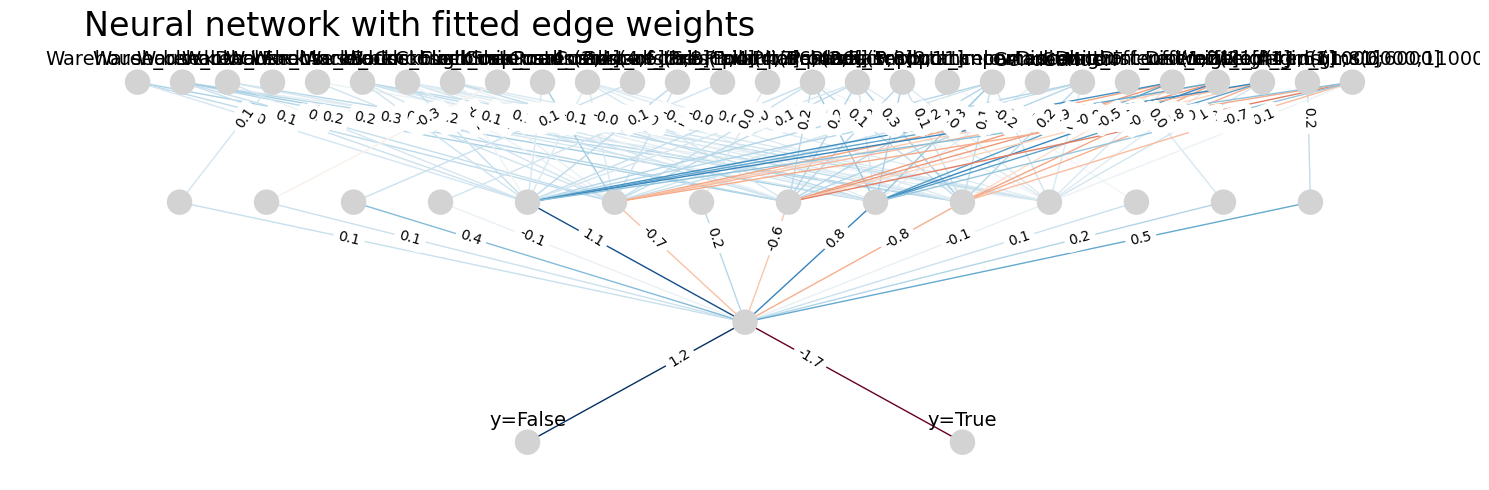

In [31]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()